In [47]:
%pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the dataset

In [48]:
df=pd.read_csv("EVChargingStationUsage.csv")
df.info()

C:\Users\33651\AppData\Local\Temp\ipykernel_3296\1098151324.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("EVChargingStationUsage.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259415 entries, 0 to 259414
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Station Name                     259415 non-null  object 
 1   MAC Address                      259415 non-null  object 
 2   Org Name                         259415 non-null  object 
 3   Start Date                       259415 non-null  object 
 4   Start Time Zone                  259415 non-null  object 
 5   End Date                         259415 non-null  object 
 6   End Time Zone                    259415 non-null  object 
 7   Transaction Date (Pacific Time)  259206 non-null  object 
 8   Total Duration (hh:mm:ss)        259415 non-null  object 
 9   Charging Time (hh:mm:ss)         259415 non-null  object 
 10  Energy (kWh)                     259415 non-null  float64
 11  GHG Savings (kg)                 259415 non-null  float64
 12  Ga

In [49]:
df.head()

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,...,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,...,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,...,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,...,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,...,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN


Change types and formats


In [50]:
df = df.drop_duplicates()
df['Start Date'] = pd.to_datetime(df['Start Date'], format="%m/%d/%Y %H:%M")
df['Total Duration (hh:mm:ss)'] = pd.to_timedelta(df['Total Duration (hh:mm:ss)'])
df['Charging Time (hh:mm:ss)'] = pd.to_timedelta(df['Charging Time (hh:mm:ss)'])


# We convert User IDs into numerical data. The errors are replaced by NaN. Then all NaN are removed.
# Doing it for energy is not necessary because it is already numerical.
df['User ID'] = pd.to_numeric(df['User ID'], errors='coerce') 
df = df.dropna(subset=['User ID'])

# dt = df.drop(['Station Name', 'MAC Address', 'End Time Zone', 'Transaction Date (Pacific Time)', 'End Date',
#              'Org Name','Currency', 'Fee','GHG Savings (kg)','Gasoline Savings (gallons)','Port Type', 'Port Number',
#             'Plug Type','Address 1','City','State/Province','Ended By','System S/N','Model Number','County',
#              'Driver Postal Code','Start Time Zone', 'EVSE ID','Postal Code', 'Country','Plug In Event Id','Latitude','Longitude'], axis=1)



Reshape the data

In [51]:




# Ajout de colonnes d'heures et de jour de la semaine
df['Hour'] = df['Start Date'].dt.hour
df['Day of Week'] = df['Start Date'].dt.dayofweek
df['Is Weekend'] = df['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)  # Weekends: Saturday & Sunday
df['Is Nighttime'] = df['Hour'].apply(lambda x: 1 if x < 6 or x >= 18 else 0)  # Nighttime: 6 PM–6 AM

# Agrégation par utilisateur
user_df = df.groupby('User ID').agg({
    'Energy (kWh)': ['mean', 'sum'],  # Mean of energy used at each charging event + total energy consumption accross all the charging events
    'Total Duration (hh:mm:ss)': lambda x: pd.to_timedelta(x).mean().total_seconds() / 3600,  # Mean in hours
    # 'Charging Time (hh:mm:ss)': lambda x: pd.to_timedelta(x).mean().total_seconds() / 3600,
    'Is Weekend': 'mean',  # Proportion de sessions le weekend
    'Is Nighttime': 'mean',  # Proportion de sessions la nuit
    'Hour': lambda x: x.mode()[0],  # Heure de début la plus fréquente
    # 'User ID': 'count'  # Number of charging events
}).reset_index()

# Renommage des colonnes
user_df.columns = ['User ID', 'Avg Energy (kWh)', 'Total Energy (kWh)', 
                   'Avg Total Duration (hrs)', 'Weekend Ratio', 'Nighttime Ratio', 'Most Frequent Hour']




In [52]:

dimensions = user_df.shape
print(user_df.head())
print(dimensions)

   User ID  Avg Energy (kWh)  Total Energy (kWh)  Avg Total Duration (hrs)  \
0      0.0          6.808841         3084.404842                  2.777704   
1    102.0          8.742773           17.485545                  2.729306   
2    107.0          4.689244           51.581688                  1.640631   
3    111.0          6.203329          117.863251                  2.275161   
4    140.0          2.000580            8.002318                  2.069861   

   Weekend Ratio  Nighttime Ratio  Most Frequent Hour  
0       0.205298         0.315673                  18  
1       0.500000         0.000000                  15  
2       0.181818         0.181818                  11  
3       0.210526         0.263158                  18  
4       0.500000         0.500000                  18  
(21420, 7)


Standardize data

In [53]:
# Standardisation des variables continues
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_df[['Avg Energy (kWh)', 'Total Energy (kWh)', 
                                                 'Avg Total Duration (hrs)', 'Weekend Ratio', 
                                                 'Nighttime Ratio']])

In [54]:
scaled_features

array([[-0.10439867,  6.77144359,  0.72953021, -0.3627559 ,  0.09082673],
       [ 0.26480771, -0.18748127,  0.69104436,  0.3653407 , -0.74174954],
       [-0.5090502 , -0.11011617, -0.17465254, -0.42076564, -0.26221102],
       ...,
       [-0.82638881, -0.22028811, -1.06642386,  1.60065067, -0.74174954],
       [-0.4451421 , -0.21575686, -0.56258611, -0.86996926, -0.74174954],
       [ 4.31423715, -0.15919   ,  2.40786981, -0.86996926, -0.74174954]])

Clustering with k-Means

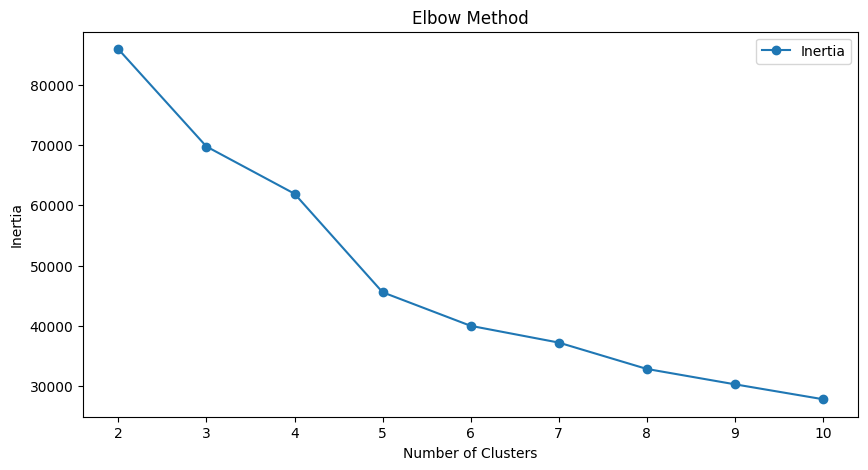

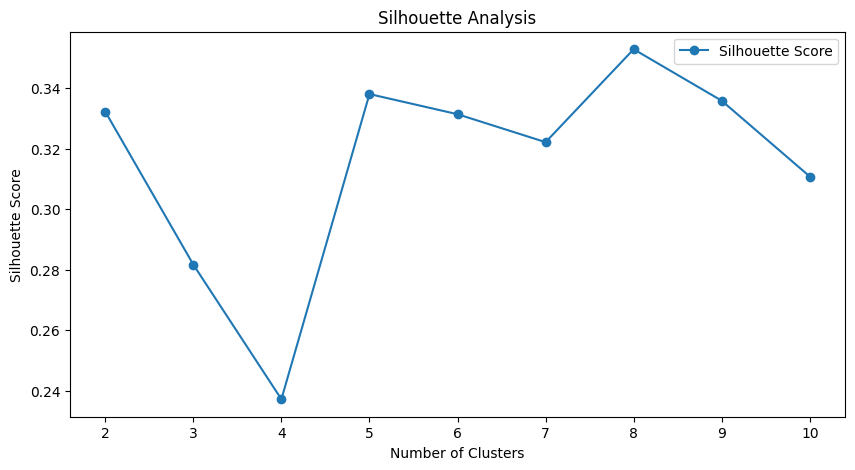

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Determine the optimal number of cluster (elbow method))
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Visualisation of the elbow method
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, marker='o', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.legend()
plt.show()

# Visualisation of the Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.legend()
plt.show()




In [56]:
# According to the graphs k=8 has been chosen. (highest Silouhette Score + or 5 with the elbow method)
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_df['Cluster'] = kmeans.fit_predict(scaled_features)

              User ID  Avg Energy (kWh)  Total Energy (kWh)  \
Cluster                                                       
0        2.893825e+06         13.040021          110.719167   
1        2.003159e+06          6.519837           35.013347   
2        2.753423e+06          6.007569           25.776091   
3        6.256909e+05         13.742643         5399.512713   
4        2.319470e+06          4.892404           42.446098   
5        4.309924e+06         29.604721          278.634431   
6        2.200738e+06          6.841449           21.151539   
7        1.435866e+06         11.303223         1661.251135   

         Avg Total Duration (hrs)  Weekend Ratio  Nighttime Ratio  \
Cluster                                                             
0                        3.076193       0.171975         0.103967   
1                        1.651266       0.723794         0.728464   
2                        1.417232       0.912972         0.036884   
3                       

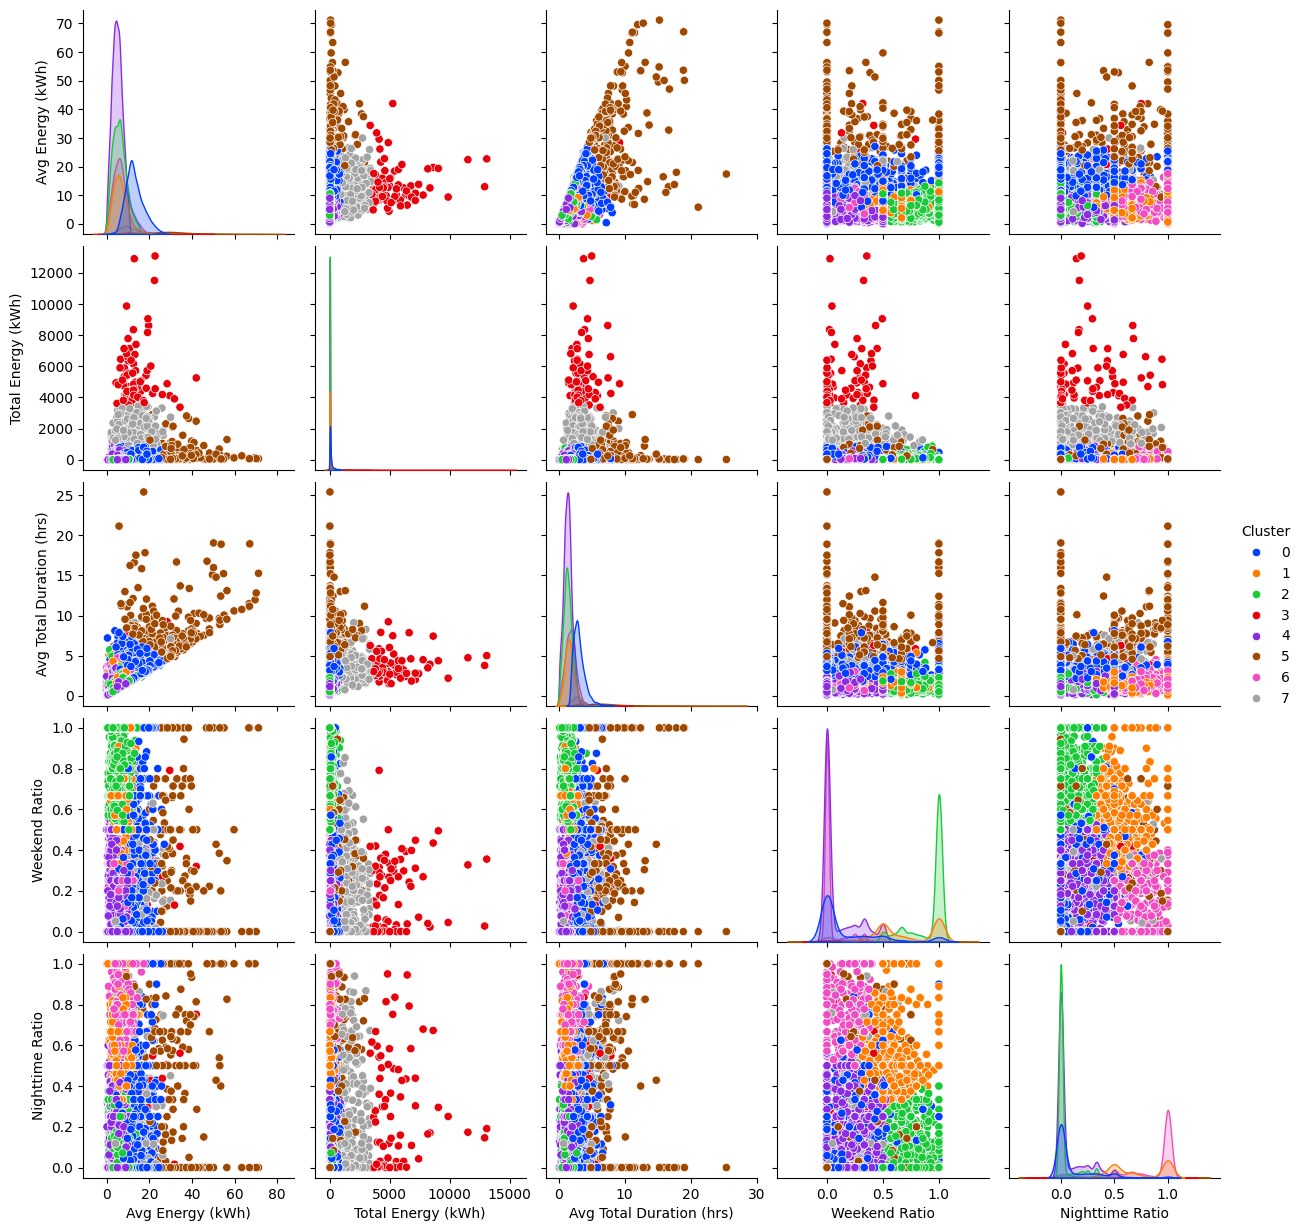

In [57]:

# Sum up of clusters
cluster_summary = user_df.groupby('Cluster').mean()

print(cluster_summary)

# Visualisation of clusters
sns.pairplot(user_df, hue='Cluster',palette='bright', vars=['Avg Energy (kWh)', 'Total Energy (kWh)','Avg Total Duration (hrs)', 
                                           'Weekend Ratio', 'Nighttime Ratio'])
plt.show()
